# Init

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
import scipy.integrate as integrate

import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

In [165]:
kb = 3.1668105e-06 # in hartree
ha2ev = 27.211386
kbev = kb*ha2ev # in eV
ba3inev= 6.2415091e-07 # bar*angstrom^3 in ev
T0=25
T1=300

## The energy units in this notebook is in eV, unless specified otherwise

# 0K results (min PE at the equilibrium size at 25K)

In [166]:
natomic=768
natomih=768
U0ih=-360654.057515
U0ic=-360654.587142

nfreeic=(natomic*3-1)*3
nfreeih=(natomih*3-1)*3

mu0ih = U0ih/natomih
mu0ic = U0ic/natomic

print(mu0ih,mu0ic,mu0ic-mu0ih)

(-469.6016373893229, -469.60232700781245, -0.000689618489559507)


# The free energy of the reference harmonic system with fixed center of mass at 25K
### $A_\text{h}(T_0)=k_B T_0\sum_{i=1}^{3N-3}\ln(\dfrac{\hbar \omega_i}{k_B T_0})$

In [167]:
T0=25
eva = np.loadtxt("icih-wrt-lambda/t-25-phonon/ih.eigval")
# The square root of the eigenvalues of the phonon modes is the frequency in the unit of hartree
AharmihT0 = T0*kb*np.log(np.sqrt(eva[3:])/(T0*kb)).sum()*ha2ev
muharmihT0 = AharmihT0/768 # 768 molecules
print(muharmihT0)

0.071764957205


In [168]:
eva = np.loadtxt("icih-wrt-lambda/t-25-phonon/ic.eigval")
# The square root of the eigenvalues of the phonon modes is the frequency in the unit of hartree
AharmicT0 = T0*kb*np.log(np.sqrt(eva[3:])/(T0*kb)).sum()*ha2ev
muharmicT0 = AharmicT0/768 # 768 molecules
print(muharmicT0)

0.0717892008194


In [169]:
print(muharmicT0-muharmihT0)

2.42436144015e-05


# Anharmonic correction of A at 25K
### $A(V,T_0)-A_h(V,T_0)=\int_0^1 d \lambda \left_{V,T_0,\lambda}$

In [170]:
dhdlih = np.loadtxt("icih-wrt-lambda/t-25-ti-lambda/ih.dhdl")
#print(dhdlih)
it=0.0
iterror=0.0
for i in range(len(dhdlih)-1):
    #print(dhdlih[i,0],dhdlih[i,1])
    it += 0.5*(dhdlih[i,1]+dhdlih[i+1,1])*(dhdlih[i+1,0]-dhdlih[i,0])
    iterror += 0.5*(dhdlih[i,2]**2.+dhdlih[i,2]**2.)*(dhdlih[i+1,0]-dhdlih[i,0])
#print(it, iterror)
AanhihT0=it
AanhihT0error=iterror
muanhT0ih = AanhihT0/768+muharmihT0
muanhT0iherror = AanhihT0error/768
print(AanhihT0, "+/-", AanhihT0error)
print(AanhihT0/768, "+/-", AanhihT0error/768)

(6.4309146639999994, '+/-', 8.9425976173080425e-08)
(0.0083735868020833326, '+/-', 1.1644007314203179e-10)


In [171]:
dhdlic = np.loadtxt("icih-wrt-lambda/t-25-ti-lambda/ic.dhdl")
#print(dhdlic)

it=0.0
iterror=0.0
for i in range(len(dhdlic)-1):
    #print(dhdlic[i,0],dhdlic[i,1])
    it += 0.5*(dhdlic[i,1]+dhdlic[i+1,1])*(dhdlic[i+1,0]-dhdlic[i,0])
    iterror += 0.5*(dhdlic[i,2]**2.+dhdlic[i,2]**2.)*(dhdlic[i+1,0]-dhdlic[i,0])
#print(it, iterror)
AanhicT0=it
AanhicT0error=iterror
muanhT0ic = AanhicT0/768+muharmicT0
muanhT0icerror = AanhicT0error/768
print(AanhicT0, "+/-", AanhicT0error)
print(AanhicT0/768, "+/-", AanhicT0error/768)

(5.9091581215000009, '+/-', 7.7193142674941231e-08)
(0.0076942163040364595, '+/-', 1.0051190452466306e-10)


In [172]:
print(muanhT0ic-muanhT0ih,muanhT0iherror+muanhT0icerror)
print(mu0ic-mu0ih)

(-0.00065512688364537108, 2.1695197766669486e-10)
-0.00068961848956


# Transform the Helmholtz free energy to the Gibbs free energy

In [173]:
A2GihT0=[0.0206629, 0.000336644]
A2GicT0=[0.0189081, 0.000507041]

muihT0=muanhT0ih+A2GihT0[0]/768
muihT0error=muanhT0icerror+A2GihT0[1]/768
print("muih 25K:",muihT0, "+/-", muihT0error)

muicT0=muanhT0ic+A2GihT0[0]/768
muicT0error=muanhT0icerror+A2GicT0[1]/768
print("muic 25K:",muicT0, "+/-", muicT0error)

print(muicT0-muihT0)

('muih 25K:', 0.080165448824806487, '+/-', 4.3843905357119133e-07)
('muic 25K:', 0.079510321941161116, '+/-', 6.6031014732119121e-07)
-0.000655126883645


# Thermodynamic integration over T at NPT

In [174]:
ttnpt = np.asarray([25, 50, 80, 100, 120, 230, 300])
ltnpt = np.log(ttnpt)
dhih = ttnpt*0.0
dhiherror = ttnpt*0.0
dhic = ttnpt*0.0
dhicerror = ttnpt*0.0

dhih = np.genfromtxt("small-icih-wrt-T/ih.pelist")[:,2]
dhiherror = np.genfromtxt("small-icih-wrt-T/ih.pelist")[:,3]
vih = np.genfromtxt("small-icih-wrt-T/ih.vlist")[:,2]
viherror = np.genfromtxt("small-icih-wrt-T/ih.vlist")[:,3]
#print(dhih)
for a in range(len(ttnpt)):
    dhih[a] += ba3inev*vih[a]-U0ih-nfreeih/2*kbev*ttnpt[a]
    dhiherror[a] += ba3inev*viherror[a]

dhic = np.genfromtxt("small-icih-wrt-T/ic.pelist")[:,2]
dhicerror = np.genfromtxt("small-icih-wrt-T/ic.pelist")[:,3]
vic = np.genfromtxt("small-icih-wrt-T/ic.vlist")[:,2]
vicerror = np.genfromtxt("small-icih-wrt-T/ic.vlist")[:,3]

#print(dhic)
for a in range(len(ttnpt)):
    dhic[a] += ba3inev*vic[a]-U0ic-nfreeic/2*kbev*ttnpt[a]
    dhicerror[a] += ba3inev*vicerror[a]

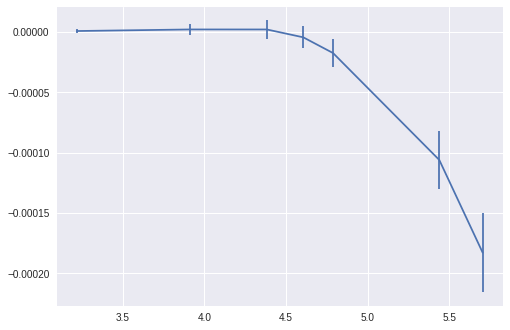

In [175]:
plt.errorbar(x=np.log(ttnpt),y=dhic/natomic-dhih/natomih,yerr=dhiherror/natomih+dhicerror/natomic)
plt.show()

#### TI wrt T, starting at T_0=25K

In [176]:
intdhih=np.zeros((len(ttnpt)-1,3))
it=0.0
iterror=0.0
j=0
for i in range(len(ttnpt)-1):
    T1=ttnpt[i+1]
    it += 0.5*(dhih[i]/ttnpt[i]+dhih[i+1]/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
    iterror += 0.5*((dhiherror[i]/ttnpt[i])**2.+(dhiherror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
    intdhih[j,0]=T1
    intdhih[j,1]=-it*T1
    intdhih[j,2]=np.sqrt(iterror)*T1
    j+=1
#print(intdhih)
#plt.plot(intdhih[:,0],intdhih[:,1])
#plt.show()

In [177]:
intdhic=np.zeros((len(ttnpt)-1,3))
it=0.0
iterror=0.0
j=0
for i in range(len(ttnpt)-1):
    T1=ttnpt[i+1]
    it += 0.5*(dhic[i]/ttnpt[i]+dhic[i+1]/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
    iterror += 0.5*((dhicerror[i]/ttnpt[i])**2.+(dhicerror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
    intdhic[j,0]=T1
    intdhic[j,1]=-it*T1
    intdhic[j,2]=np.sqrt(iterror)*T1
    j+=1
#print(intdhic)
#plt.plot(intdhic[:,0],intdhic[:,1])
#plt.show()

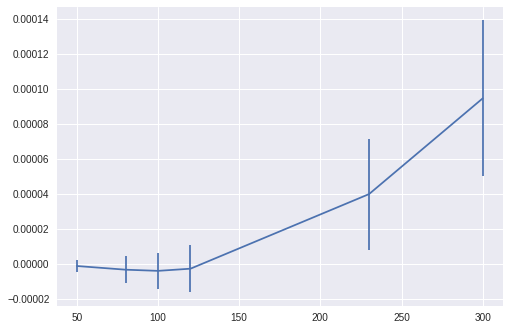

In [178]:
plt.errorbar(x=ttnpt[1:],y=intdhic[:,1]/natomic-intdhih[:,1]/natomih,yerr=intdhih[:,2]/natomih+intdhic[:,2]/natomic)
plt.show()

## Now we put all the pieces together
## From the paper we have
###  $\dfrac{A(V,T_1)}{k_B T_1} = \dfrac{A(V,0)}{k_B T_1}+ \dfrac{A(V,T_0) - A(V,0)}{k_B T_0} -(3N-3) \ln(\dfrac{T_1}{T_0})- \int_{T_0}^{T_1} \dfrac{\left<\delta U\right>_{V,T}}{k_B T^2} dT.$
### so
### $A(V,T_1) =A(V,0)+ \dfrac{T_1}{T_0}(A(V,T_0) - A(V,0)) -(3N-3)k_B T_1 \ln(\dfrac{T_1}{T_0})-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta U\right>_{V,T}e^{-y} dy$
### Note: These expressions are for systems with constrained center of mass

In [179]:
muih=np.zeros((len(ttnpt)-1,3))
for i in range(len(ttnpt)-1):
    T1=intdhih[i,0]
    muih[i,0]=T1
    muih[i,1]=intdhih[i,1]/natomih+mu0ih+(T1/T0)*(muihT0-mu0ih)-3*kbev*T1*np.log(T1/T0)
    muih[i,2]=intdhih[i,2]/natomih+(T1/T0)*muihT0error
#print(muih)

In [180]:
muic=np.zeros((len(ttnpt)-1,3))
for i in range(len(ttnpt)-1):
    T1=intdhic[i,0]
    muic[i,0]=T1
    muic[i,1]=intdhic[i,1]/natomic+mu0ic+(T1/T0)*(muicT0-mu0ic)-3*kbev*T1*np.log(T1/T0)
    muic[i,2]=intdhic[i,2]/natomic+(T1/T0)*muicT0error
#print(muic)

# This the free energy associated with the center of mass for the two system should almost cancel out at this system size

# Now compute the trapping free energy (classical)

In [181]:
muicih=np.zeros((len(ttnpt)-1,3))
for i in range(len(ttnpt)-1):
    muicih[i,0]=muic[i,0]
    muicih[i,1]=muic[i,1]-muih[i,1]
    muicih[i,2]=np.sqrt(muic[i,2]**2.0+muih[i,2]**2.0)
#print(muicih)

In [182]:
# this is the harmonic contribution
muicihharm=np.zeros((len(ttnpt)-1,2))
for i in range(len(ttnpt)-1):
    muicihharm[i,0]=muic[i,0]
    muicihharm[i,1]=(-mu0ih+mu0ic)+(muharmicT0-muharmihT0)*(muic[i,0]/T0)

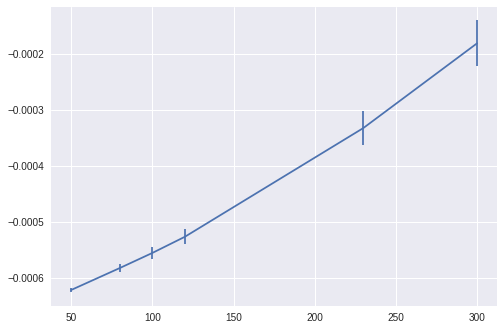

In [183]:
plt.errorbar(x=muicih[:,0], y=muicih[:,1], yerr=muicih[:,2])
#plt.plot(muicihharm[:,0],muicihharm[:,1])
plt.show()

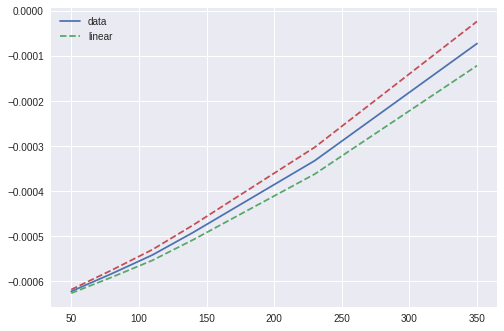

In [184]:
fmu = interp1d(muicih[:,0],muicih[:,1],bounds_error=False,fill_value='extrapolate')
fmuerror = interp1d(muicih[:,0], muicih[:,2],bounds_error=False,fill_value='extrapolate')
xnew = np.linspace(50, 350, num=11, endpoint=True)
plt.plot( xnew, fmu(xnew), '-',xnew, fmu(xnew)-fmuerror(xnew), '--',xnew, fmu(xnew)+fmuerror(xnew), '--')
plt.legend(['data', 'linear'], loc='best')
plt.show()

# Now let's add quantum contribution

# From classical to quantum
## $A(m') - A(m) = \dfrac{3}{2 \beta} \log \dfrac{m'}{m} -\int_m^{m'} \dfrac{<T(u)>}{u} d u$
## neglecting the constant, the free energy contribution from NQE is
## $A(m_H) = A(m_{\infty}) +  \int_{mH}^{m_{\infty}} \dfrac{<T(u)>}{u} d u$
## Do substitution $u=1/y^2$ and we have
## $A(m_H) = A(m_{\infty}) -  \int_1^{0} 2\dfrac{<T(1/y^2)>}{y} d y=A(m_{\infty}) +  \int_0^{1} 2\dfrac{<T(1/y^2)>}{y} d y$

In [185]:
Hmasslist = np.asarray([1, 2, 4, 8, 16])
ylist = np.sqrt(1./Hmasslist)
print(ylist)

[ 1.          0.70710678  0.5         0.35355339  0.25      ]


In [186]:
tcvic273 = np.genfromtxt("pimd-wrt-m/ic-273K.ktcv")[:,:]
tcvih273 = np.genfromtxt("pimd-wrt-m/ih-273K.ktcv")[:,:]

tcvic300 = np.genfromtxt("pimd-wrt-m/ic-300K.ktcv")[:,:]
tcvih300 = np.genfromtxt("pimd-wrt-m/ih-300K.ktcv")[:,:]

tcvic250 = np.genfromtxt("pimd-wrt-m/ic-250K.ktcv")[:,:]
tcvih250 = np.genfromtxt("pimd-wrt-m/ih-250K.ktcv")[:,:]

tcvic200 = np.genfromtxt("pimd-wrt-m/ic-200K.ktcv")[:,:]
tcvih200 = np.genfromtxt("pimd-wrt-m/ih-200K.ktcv")[:,:]

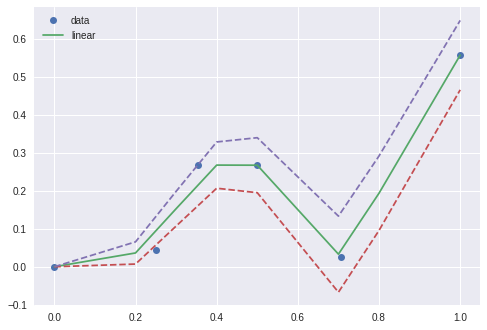

(0.08521715092558672, '+/-', 0.028914280309782877)
(0.17654250425926912, '+/-', 0.06487474603248075)


In [187]:
tcvic=tcvic273
tcvih=tcvih273
x = np.append(ylist,0)
y = np.append(2.*(tcvic[:,1]-tcvih[:,1])/ylist,0)
yerror = np.append(np.sqrt(tcvic[:,2]**2.+ tcvih[:,2]**2.),0)
fdtcv = interp1d(x, y,bounds_error=False,fill_value='extrapolate')
fdtcverror = interp1d(x, yerror,bounds_error=False,fill_value='extrapolate')

xnew = np.linspace(0, 1, num=11, endpoint=True)
plt.plot(x, y, 'o', xnew, fdtcv(xnew), '-',xnew, fdtcv(xnew)-fdtcverror(xnew), '--',xnew, fdtcv(xnew)+fdtcverror(xnew), '--')
plt.legend(['data', 'linear'], loc='best')
plt.show()

d2h273K = integrate.quad(lambda x: fdtcv(x), 1./np.sqrt(2.), 1)[0] # approximate value because the mass of oxygen is changed
d2h273Kerror = integrate.quad(lambda x: fdtcverror(x), 0.7, 1)[0]
print(d2h273K, '+/-', d2h273Kerror)

nqe273K = integrate.quad(lambda x: fdtcv(x), 0.0, 1)[0]
nqe273Kerror = integrate.quad(lambda x: fdtcverror(x), 0.0, 1)[0]
print(nqe273K, '+/-', nqe273Kerror)

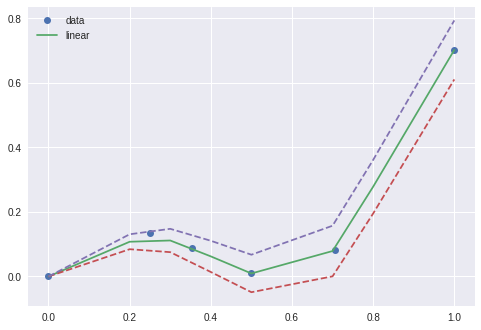

(0.11468396228295268, '+/-', 0.02553343887672755)
(0.15939965565060563, '+/-', 0.054026747224196175)


In [188]:
tcvic=tcvic300
tcvih=tcvih300
x = np.append(ylist,0)
y = np.append(2.*(tcvic[:,1]-tcvih[:,1])/ylist,0)
yerror = np.append(np.sqrt(tcvic[:,2]**2.+ tcvih[:,2]**2.),0)
fdtcv = interp1d(x, y,bounds_error=False,fill_value='extrapolate')
fdtcverror = interp1d(x, yerror,bounds_error=False,fill_value='extrapolate')

xnew = np.linspace(0, 1, num=11, endpoint=True)
plt.plot(x, y, 'o', xnew, fdtcv(xnew), '-',xnew, fdtcv(xnew)-fdtcverror(xnew), '--',xnew, fdtcv(xnew)+fdtcverror(xnew), '--')
plt.legend(['data', 'linear'], loc='best')
plt.show()

d2h300K = integrate.quad(lambda x: fdtcv(x), 1./np.sqrt(2.), 1)[0]
d2h300Kerror = integrate.quad(lambda x: fdtcverror(x), 0.7, 1)[0]
print(d2h300K, '+/-', d2h300Kerror)

nqe300K = integrate.quad(lambda x: fdtcv(x), 0.0, 1)[0]
nqe300Kerror = integrate.quad(lambda x: fdtcverror(x), 0.0, 1)[0]
print(nqe300K, '+/-', nqe300Kerror)

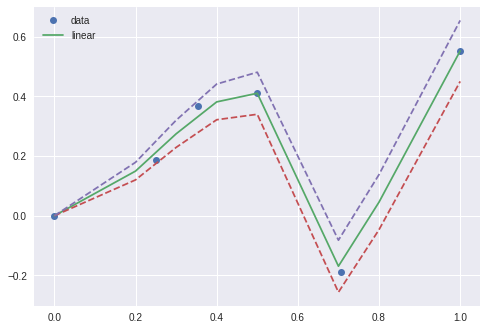

(0.0531559850820443, '+/-', 0.028465132828756293)
(0.18524769448749426, '+/-', 0.06278347600516648)


In [189]:
tcvic=tcvic250
tcvih=tcvih250
x = np.append(ylist,0)
y = np.append(2.*(tcvic[:,1]-tcvih[:,1])/ylist,0)
yerror = np.append(np.sqrt(tcvic[:,2]**2.+ tcvih[:,2]**2.),0)
fdtcv = interp1d(x, y,bounds_error=False,fill_value='extrapolate')
fdtcverror = interp1d(x, yerror,bounds_error=False,fill_value='extrapolate')

xnew = np.linspace(0, 1, num=11, endpoint=True)
plt.plot(x, y, 'o', xnew, fdtcv(xnew), '-',xnew, fdtcv(xnew)-fdtcverror(xnew), '--',xnew, fdtcv(xnew)+fdtcverror(xnew), '--')
plt.legend(['data', 'linear'], loc='best')
plt.show()

d2h250K = integrate.quad(lambda x: fdtcv(x), 1./np.sqrt(2.), 1)[0]
d2h250Kerror = integrate.quad(lambda x: fdtcverror(x), 0.7, 1)[0]
print(d2h250K, '+/-', d2h250Kerror)

nqe250K = integrate.quad(lambda x: fdtcv(x), 0.0, 1)[0]
nqe250Kerror = integrate.quad(lambda x: fdtcverror(x), 0.0, 1)[0]
print(nqe250K, '+/-', nqe250Kerror)

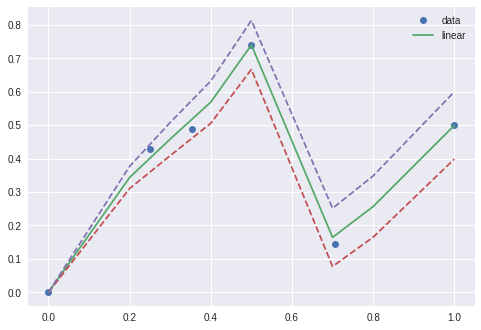

(0.09411392430645364, '+/-', 0.028174602635210044)
(0.376859083104912, '+/-', 0.06421530438879704)


In [190]:
tcvic=tcvic200
tcvih=tcvih200
x = np.append(ylist,0)
y = np.append(2.*(tcvic[:,1]-tcvih[:,1])/ylist,0)
yerror = np.append(np.sqrt(tcvic[:,2]**2.+ tcvih[:,2]**2.),0)
fdtcv = interp1d(x, y,bounds_error=False,fill_value='extrapolate')
fdtcverror = interp1d(x, yerror,bounds_error=False,fill_value='extrapolate')

xnew = np.linspace(0, 1, num=11, endpoint=True)
plt.plot(x, y, 'o', xnew, fdtcv(xnew), '-',xnew, fdtcv(xnew)-fdtcverror(xnew), '--',xnew, fdtcv(xnew)+fdtcverror(xnew), '--')
plt.legend(['data', 'linear'], loc='best')
plt.show()

d2h200K = integrate.quad(lambda x: fdtcv(x), 1./np.sqrt(2.), 1)[0]
d2h200Kerror = integrate.quad(lambda x: fdtcverror(x), 0.7, 1)[0]
print(d2h200K, '+/-', d2h200Kerror)

nqe200K = integrate.quad(lambda x: fdtcv(x), 0.0, 1)[0]
nqe200Kerror = integrate.quad(lambda x: fdtcverror(x), 0.0, 1)[0]
print(nqe200K, '+/-', nqe200Kerror)

In [191]:
nqe=np.zeros((4,3))
nqe[0,:] = [200, nqe200K/1000., nqe200Kerror/1000.]
nqe[1,:] = [250, nqe250K/1000., nqe250Kerror/1000.] 
nqe[2,:] = [273, nqe273K/1000., nqe273Kerror/1000.] 
nqe[3,:] = [300, nqe300K/1000., nqe300Kerror/1000.] 
print(nqe)

[[  2.00000000e+02   3.76859083e-04   6.42153044e-05]
 [  2.50000000e+02   1.85247694e-04   6.27834760e-05]
 [  2.73000000e+02   1.76542504e-04   6.48747460e-05]
 [  3.00000000e+02   1.59399656e-04   5.40267472e-05]]


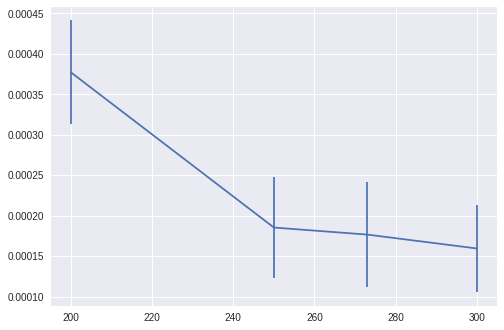

In [192]:
plt.errorbar(x=nqe[:,0], y=nqe[:,1], yerr=nqe[:,2])
plt.show()

The molar enthalpy of fusion for ice at 0 °C has an accepted value of +6.01 kJ/mol.
that is 62 meV.

H_f/T_m = 0.2 meV / K

# Now add NQES

In [193]:
pimdmu = np.zeros((len(nqe),3))
for i in range(len(nqe)):
    pimdmu[i,0] =  nqe[i,0]
    pimdmu[i,1] =  nqe[i,1] + fmu(nqe[i,0])
    pimdmu[i,2] =  nqe[i,2] + fmuerror(nqe[i,0])
print(pimdmu)

[[  2.00000000e+02  -8.63797246e-06   8.94133448e-05]
 [  2.50000000e+02  -1.03969302e-04   9.56696373e-05]
 [  2.73000000e+02  -6.29435202e-05   1.01458681e-04]
 [  3.00000000e+02  -2.17065318e-05   9.49515478e-05]]


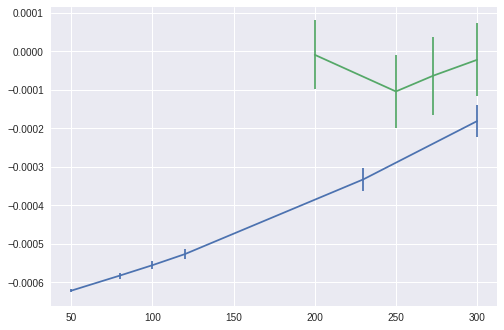

In [194]:
plt.errorbar(x=muicih[:,0], y=muicih[:,1], yerr=muicih[:,2])
plt.errorbar(x=pimdmu[:,0], y=pimdmu[:,1], yerr=pimdmu[:,2])
#plt.errorbar(x=difdft[:,0], y=difdft[:,1]+fmu(difdft[:,0])+nqe273K/1000, yerr=difdft[:,2]+fmuerror(difdft[:,0])+nqe273Kerror/1000)
plt.show()

# Now add NN->DFT correction (classical)

In [195]:
ih2dft = np.genfromtxt("ice-nn-2-dft/ih-avgdmu-t.dat")[:]
print(ih2dft)

[[  1.00000000e+02  -1.68807000e-03   1.33226000e-04]
 [  1.50000000e+02  -1.29764000e-03   1.59125000e-04]
 [  2.00000000e+02  -7.92190000e-04   9.81141000e-05]
 [  2.50000000e+02  -5.11960000e-04   1.11002000e-04]
 [  3.00000000e+02  -8.11746000e-04   1.34305000e-04]]


In [196]:
ic2dft = np.genfromtxt("ice-nn-2-dft/ic-avgdmu-t.dat")[:]
print(ic2dft)

[[  1.00000000e+02  -1.52951000e-03   6.67432000e-05]
 [  1.50000000e+02  -1.18789000e-03   7.66368000e-05]
 [  2.00000000e+02  -9.22505000e-04   7.52657000e-05]
 [  2.50000000e+02  -6.69848000e-04   8.35466000e-05]
 [  3.00000000e+02  -5.21656000e-04   6.06115000e-05]]


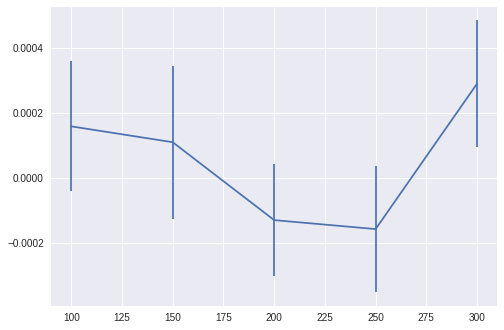

In [197]:
difdft = ih2dft
difdft[:,1] = ic2dft[:,1] - ih2dft[:,1]
difdft[:,2] = ic2dft[:,2] + ih2dft[:,2]
plt.errorbar(x=difdft[:,0], y=difdft[:,1], yerr=difdft[:,2])
#plt.plot(muicihharm[:,0],muicihharm[:,1])
plt.show()

In [198]:
dftmuicih = difdft
for i in range(len(difdft)):
    dftmuicih[i,1]=difdft[i,1]+fmu(difdft[i,0])
    dftmuicih[i,2]==difdft[i,2]+fmuerror(difdft[i,0])

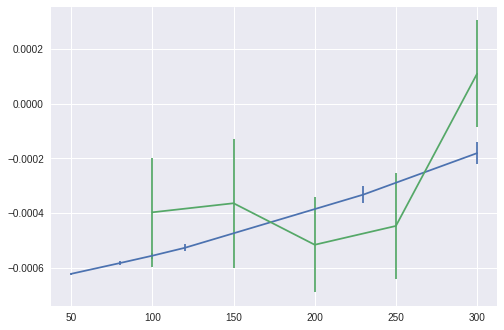

In [199]:
plt.errorbar(x=muicih[:,0], y=muicih[:,1], yerr=muicih[:,2])
plt.errorbar(x=dftmuicih[:,0], y=dftmuicih[:,1], yerr=dftmuicih[:,2])
#plt.errorbar(x=difdft[:,0], y=difdft[:,1]+fmu(difdft[:,0])+nqe273K/1000, yerr=difdft[:,2]+fmuerror(difdft[:,0])+nqe273Kerror/1000)
plt.show()

In [200]:
fdftmu = interp1d(dftmuicih[:,0],dftmuicih[:,1],bounds_error=False,fill_value='extrapolate')
fdftmuerror = interp1d(dftmuicih[:,0], dftmuicih[:,2],bounds_error=False,fill_value='extrapolate')

# compare with another set of data

In [201]:
nn1mu=np.genfromtxt("nn-1/nn-1.muicih")[:]
nn1dftmu=np.genfromtxt("nn-1/nn-1.dftmuicih")[:]

In [202]:
print(nn1dftmu)

[[  1.00000000e+02  -6.77821458e-05   2.17496400e-04]
 [  1.50000000e+02  -1.90735454e-04   1.90213600e-04]
 [  2.00000000e+02  -3.07555670e-04   3.26893000e-04]
 [  2.50000000e+02   1.41669649e-04   3.56080000e-04]
 [  3.00000000e+02   3.47135163e-04   3.15538000e-04]]


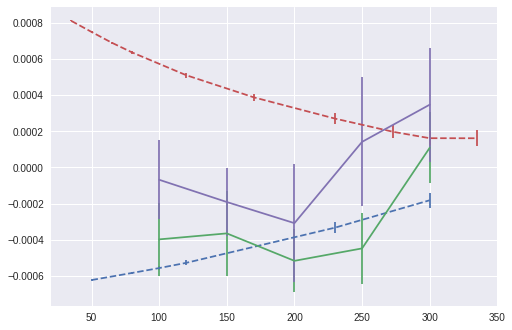

In [203]:
plt.errorbar(x=muicih[:,0], y=muicih[:,1], yerr=muicih[:,2],ls='--')
plt.errorbar(x=dftmuicih[:,0], y=dftmuicih[:,1], yerr=dftmuicih[:,2])
#plt.errorbar(x=dftmuicih[:,0], y=dftmuicih[:,1]+nqe273K/1000, yerr=dftmuicih[:,2]+nqe273Kerror/1000)
plt.errorbar(x=nn1mu[:,0], y=nn1mu[:,1], yerr=nn1mu[:,2],ls='--')
plt.errorbar(x=nn1dftmu[:,0], y=nn1dftmu[:,1], yerr=nn1dftmu[:,2])
plt.show()

# Now add NQES and DFT correction

In [204]:
dftpimdmu = np.zeros((len(nqe),3))
for i in range(len(nqe)):
    dftpimdmu[i,0] =  nqe[i,0]
    dftpimdmu[i,1] =  nqe[i,1] + fdftmu(nqe[i,0])
    dftpimdmu[i,2] =  nqe[i,2] + fdftmuerror(nqe[i,0])
print(dftpimdmu)

[[  2.00000000e+02  -1.38952972e-04   2.37595104e-04]
 [  2.50000000e+02  -2.61857302e-04   2.57332076e-04]
 [  2.73000000e+02  -1.47616402e-05   2.59592580e-04]
 [  3.00000000e+02   2.68383468e-04   2.48943247e-04]]


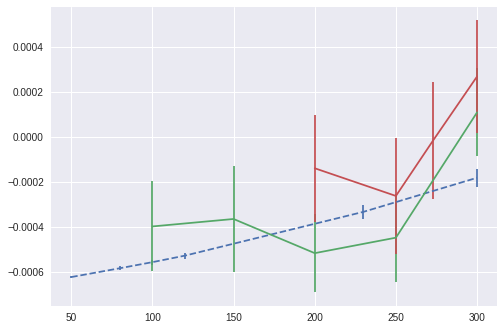

In [205]:
plt.errorbar(x=muicih[:,0], y=muicih[:,1], yerr=muicih[:,2],ls='--')
plt.errorbar(x=dftmuicih[:,0], y=dftmuicih[:,1], yerr=dftmuicih[:,2])
plt.errorbar(x=dftpimdmu[:,0], y=dftpimdmu[:,1], yerr=dftpimdmu[:,2])
plt.show()

# Plots

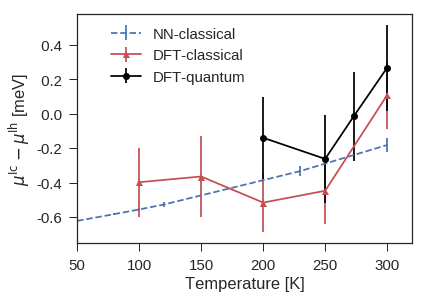

In [206]:
pallete = sns.color_palette()
fout = 'fig_3.png'
#fout = None
with sns.plotting_context("notebook", font_scale=1.5):
    with sns.axes_style("ticks",{"xtick.major.size": 8, "ytick.major.size": 8,"xtick.minor.size": 4, "ytick.minor.size": 4}):
        f, ax = plt.subplots(1,  figsize=np.array([1, 0.7]) * 6)
        
        #ax.plot( np.arange(0.0,500),0*np.arange(0.0,500),c="gray",linewidth=1.0)
        ax.errorbar(x=muicih[:,0], y=muicih[:,1]*1000, yerr=muicih[:,2]*1000,ls='dashed', label='NN-classical')
        ax.errorbar(x=dftmuicih[:,0], y=dftmuicih[:,1]*1000, yerr=dftmuicih[:,2]*1000,c=pallete[2], marker='^', label='DFT-classical')
        ax.errorbar(x=dftpimdmu[:,0], y=dftpimdmu[:,1]*1000, yerr=dftpimdmu[:,2]*1000,c="black", marker='o', label='DFT-quantum')
        #ax.grid(linestyle='--', linewidth=1)
        ax.set(xlabel='Temperature [K]', ylabel='$\mu^\mathrm{Ic}-\mu^\mathrm{Ih}$ [meV]')    
        #ax.set_ylim([0.86,1.008])
        ax.set_xlim([50, 320])
        ax.legend(loc='center right', bbox_to_anchor=(0.52, 0.82), borderaxespad=0.)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%4.1f'))

        if fout:
            f.savefig(fout, dpi=300, bbox_inches='tight')
plt.show()

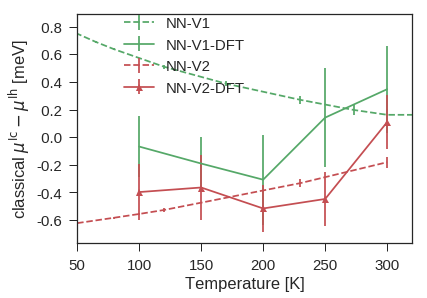

In [207]:
pallete = sns.color_palette()
fout = 'si-fig_3.png'
#fout = None
with sns.plotting_context("notebook", font_scale=1.5):
    with sns.axes_style("ticks",{"xtick.major.size": 8, "ytick.major.size": 8,"xtick.minor.size": 4, "ytick.minor.size": 4}):
        f, ax = plt.subplots(1,  figsize=np.array([1, 0.7]) * 6)
        
        
        ax.errorbar(x=nn1mu[:,0], y=nn1mu[:,1]*1000, yerr=nn1mu[:,2]*1000,c=pallete[1],ls='--', label='NN-V1')
        ax.errorbar(x=nn1dftmu[:,0], y=nn1dftmu[:,1]*1000, yerr=nn1dftmu[:,2]*1000,c=pallete[1],label='NN-V1-DFT')
        ax.errorbar(x=muicih[:,0], y=muicih[:,1]*1000, yerr=muicih[:,2]*1000,ls='dashed',c=pallete[2], label='NN-V2')
        ax.errorbar(x=dftmuicih[:,0], y=dftmuicih[:,1]*1000, yerr=dftmuicih[:,2]*1000,c=pallete[2], marker='^', label='NN-V2-DFT')
        #ax.errorbar(x=dftpimdmu[:,0], y=dftpimdmu[:,1]*1000, yerr=dftpimdmu[:,2]*1000,c="black", marker='o', label='DFT-quantum')
        #ax.grid(linestyle='--', linewidth=1)
        ax.set(xlabel='Temperature [K]', ylabel='classical $\mu^\mathrm{Ic}-\mu^\mathrm{Ih}$ [meV]')    
        #ax.set_ylim([0.86,1.008])
        ax.set_xlim([50, 320])
        ax.legend(loc='center right', bbox_to_anchor=(0.52, 0.82), borderaxespad=0.)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%4.1f'))

        if fout:
            f.savefig(fout, dpi=300, bbox_inches='tight')
plt.show()

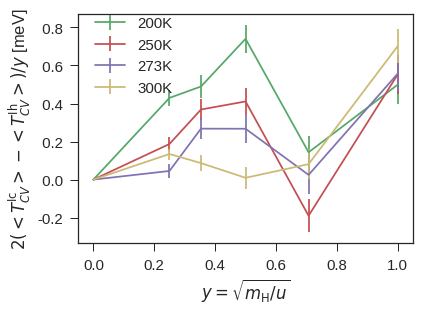

In [208]:
pallete = sns.color_palette()
fout = 'si-fig_4.png'
#fout = None
with sns.plotting_context("notebook", font_scale=1.5):
    with sns.axes_style("ticks",{"xtick.major.size": 8, "ytick.major.size": 8,"xtick.minor.size": 4, "ytick.minor.size": 4}):
        f, ax = plt.subplots(1,  figsize=np.array([1, 0.7]) * 6)

        tcvic=tcvic200
        tcvih=tcvih200
        x = np.append(ylist,0)
        y = np.append(2.*(tcvic[:,1]-tcvih[:,1])/ylist,0)
        yerror = np.append(np.sqrt(tcvic[:,2]**2.+ tcvih[:,2]**2.),0)
        ax.errorbar(x, y, yerr=yerror,c=pallete[1], label='200K')
        
        tcvic=tcvic250
        tcvih=tcvih250
        x = np.append(ylist,0)
        y = np.append(2.*(tcvic[:,1]-tcvih[:,1])/ylist,0)
        yerror = np.append(np.sqrt(tcvic[:,2]**2.+ tcvih[:,2]**2.),0)
        ax.errorbar(x, y, yerr=yerror,c=pallete[2], label='250K')

        
        tcvic=tcvic273
        tcvih=tcvih273
        x = np.append(ylist,0)
        y = np.append(2.*(tcvic[:,1]-tcvih[:,1])/ylist,0)
        yerror = np.append(np.sqrt(tcvic[:,2]**2.+ tcvih[:,2]**2.),0)
        ax.errorbar(x, y, yerr=yerror,c=pallete[3], label='273K')

        tcvic=tcvic300
        tcvih=tcvih300
        x = np.append(ylist,0)
        y = np.append(2.*(tcvic[:,1]-tcvih[:,1])/ylist,0)
        yerror = np.append(np.sqrt(tcvic[:,2]**2.+ tcvih[:,2]**2.),0)
        ax.errorbar(x, y, yerr=yerror,c=pallete[4], label='300K')
        
        ax.set(xlabel='$y=\sqrt{m_\mathrm{H}/u}$', ylabel='$2(<T_{CV}^\mathrm{Ic}>-<T_{CV}^\mathrm{Ih}>)/y$ [meV]')    
        #ax.set_ylim([0.86,1.008])
        #ax.set_xlim([50, 320])
        ax.legend(loc='center right', bbox_to_anchor=(0.3, 0.82), borderaxespad=0.)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%4.1f'))

        if fout:
            f.savefig(fout, dpi=300, bbox_inches='tight')
plt.show()